In [1]:
#%reset_selective <regular_expression>
import os 
import numpy as np
import matplotlib.pyplot as plt
import random
from bssfp import bssfp, add_noise_gaussian
from phantom_joint import mr_joint_phantom, get_phantom
from phantom_brainweb import mr_brain_web_phantom, brain_web_loader,offres_gen, mr_brain_web_SNR
from planet2 import planet

In [2]:
N = 128 # NxN resolution, 
npcs = 6 # npcs = number of phase-cycle

#Brain phantom 
dir = '/Users/yiten/Documents/MRI Relaxometry/BrainWeb' #Change to your directory of BrainWeb
#dir = '/Users/User/Documents/MRI Relaxometry/BrainWeb' #Change to your directory of BrainWeb
data =  brain_web_loader(dir)

#randomize frequency, check inhomogeneity range
freq = 1000 * random.uniform(0,1)
print('Off-resonance frequency range: '+'{:.2f}'.format(freq))
offres = offres_gen(N,f=freq, rotate=True, deform=True) 

# alpha = flip angle
alpha = np.deg2rad(60)

Off-resonance frequency range: 469.08


Number of CSF pixels: 754
Number of GM pixels: 2235
Number of WM pixels: 2059
(40, 28)


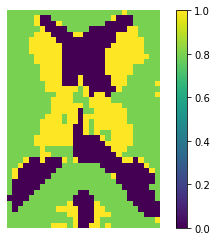

In [3]:
#Create brain phantom
phantom = mr_brain_web_phantom(data,alpha,offres=offres)
#Get phantom parameter
M0, T1, T2, flip_angle,df, sample = get_phantom(phantom)
n_csf,n_gm,n_wm = 0,0,0
for i in range(np.shape(sample)[0]):
    for j in range(np.shape(sample)[1]):
        if sample[i,j] ==1:
            n_csf+=1
        if sample[i,j] ==2:
            n_gm += 1
        if sample[i,j] ==3:
            n_wm += 1
print('Number of CSF pixels:', n_csf)
print('Number of GM pixels:', n_gm)
print('Number of WM pixels:', n_wm)
T2_cropped = T2[43:83, 50:78]
T2_cropped = (T2_cropped - np.min(T2_cropped))/(np.max(T2_cropped)-np.min(T2_cropped))
im = plt.imshow(T2_cropped)
plt.colorbar(im)
plt.axis('off')
print(T2_cropped.shape)

(-0.5, 127.5, 127.5, -0.5)

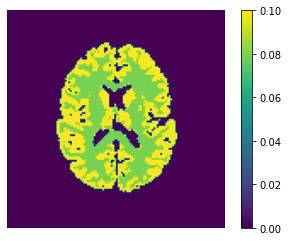

In [4]:
im = plt.imshow(T2)
plt.colorbar(im)
plt.axis('off')
#plt.savefig('T2.png')

(-0.5, 127.5, 127.5, -0.5)

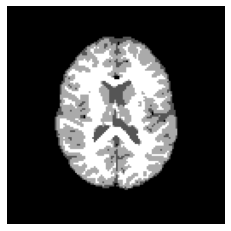

In [5]:
plt.imshow(sample,cmap='gray')
plt.axis('off')

(-0.5, 27.5, 39.5, -0.5)

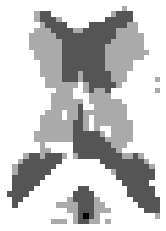

In [6]:
sample = sample[43:83, 50:78]
plt.imshow(sample,cmap='gray')
plt.axis('off')

In [7]:
# Simulate bSSFP acquisition with linear off-resonance
TR = 3e-3
pcs = np.linspace(0, 2 * np.pi, npcs, endpoint=False)
sig = bssfp(T1, T2, TR, flip_angle, field_map=df, phase_cyc=pcs, M0=M0)
print(sig.shape)

(6, 128, 128)


<ipython-input-14-c90be3b48613>:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(2, npcs / 2, n)


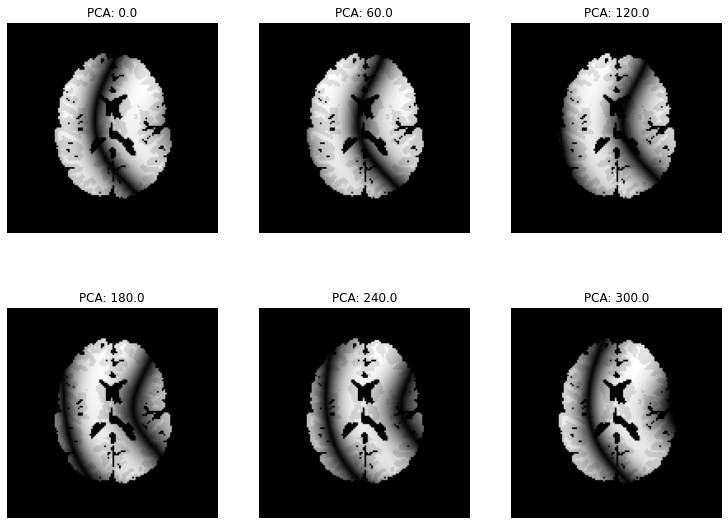

In [14]:
# Display phase-cycled images without noise
plt.figure(2, figsize=(12.8, 9.6))
for n in range(1, npcs + 1):
    plt.subplot(2, npcs / 2, n)
    plt.imshow(np.abs(sig[n - 1]),cmap='gray')
    plt.axis('off')
    plt.title("PCA: %.1f" %np.rad2deg(pcs[n - 1]))
plt.show()


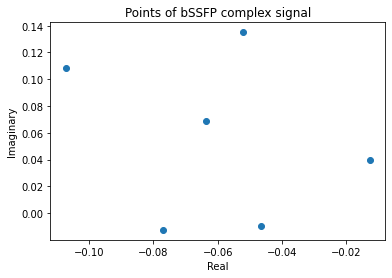

In [9]:
#Add Gaussian noise to phase-cycled images
noise_level = random.uniform(0.05,0.01)
sig_noise = add_noise_gaussian(sig, sigma=noise_level)
sig_noise_test = sig_noise[:,64,64]
plt.figure()
plt.scatter(sig_noise_test.real,sig_noise_test.imag)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Points of bSSFP complex signal')
plt.show()

In [10]:
training_data = sig_noise[0]
training_data = training_data[43:83, 50:78]
for i in range(1,6):
    training_data = np.concatenate([training_data, sig_noise[i][43:83, 50:78]], axis=1) 

print(training_data.shape)

(40, 168)


In [11]:
_, _, planet_T2, _ = planet(sig_noise[:,95,95], alpha=alpha, TR=TR, T1_guess=2, pcs=pcs, mask=None, pc_axis=-1, ret_all=False)
print(planet_T2)
# pc_axis = 0
# print(sig_noise_test)
# sig_noise_test = np.moveaxis(sig_noise_test, pc_axis, -1)
# print(sig_noise_test)
# npcs = sig_noise_test.shape[-1]
# print(npcs)
# sh = sig_noise_test.shape[:-1]
# print(sh)
# print(int(np.prod(sh)))

-40.28486243526309
c:\Users\yiten\Documents\FYP (Python)\bssfp_data_generator\planet2.py:175: RuntimeWarning: invalid value encountered in sqrt
  Coef = (a - b)/(a*np.sqrt(1 - bb2))  # Coef=A/B


In [12]:
# print(sig_noise_test[0].real)
complex_data = np.zeros([1,12])
for i in range(6):
    complex_data[:,2*i] = sig_noise_test[i].real
    complex_data[:,2*i+1] = sig_noise_test[i].imag
print(complex_data.shape)
print(complex_data)

(1, 12)
[[-0.07706469 -0.01259315 -0.04649128 -0.00954758 -0.01260287  0.03999158
  -0.05202757  0.13511794 -0.10732341  0.10815279 -0.06375746  0.06880199]]


In [13]:
snr_csf, snr_gm, snr_wm = mr_brain_web_SNR(sig_noise, phantom, noise_level)
print('SNR(CSF): '+'{:.2f}'.format(snr_csf))
print('SNR(GM): '+'{:.2f}'.format(snr_gm))
print('SNR(WM): '+'{:.2f}'.format(snr_wm))

ValueError: too many values to unpack (expected 3)

In [ ]:
# Display phase-cycled images with noise
#plt.figure(figsize=(12.8, 9.6))
#plt.title('Phase_Cycled images with noise')
#for n in range(1, npcs + 1):
    #print(np.abs(sig_noise[n - 1, 50, 50]))
    #plt.subplot(2, npcs / 2, n)
    #plt.imshow(np.abs(sig_noise[n - 1]))
    #plt.title('PC %d Degrees' % np.rad2deg(pcs[n - 1]))
    #plt.axis('off')
#plt.savefig('test.png')

In [ ]:
#os.chdir('c:\\Users\\yiten\\Documents\\FYP (Python)')
#os.chdir('c:\\Users\\User\\Documents\\FYP-Python')

In [ ]:
#Concatenate 
# test_image = np.abs(sig_noise[0])
# plt.imshow(test_image)
# plt.axis('off')
# plt.savefig('p1.png')
# for i in range(1,6):
#     print(i)
#     test_image = np.concatenate([test_image, np.abs(sig_noise[i])],axis=1) #axis = 1 column wise, 0 row wise
# print(test_image.shape)
# plt.imshow(test_image)
# plt.axis('off')
# plt.savefig('test_image2.png')

In [ ]:
# plt.imsave('test_image.png',np.abs(sig_noise[0][43:83, 50:78]))
# plt.imshow(np.abs(sig_noise[0][43:83, 50:78]))
# plt.axis('off')
# plt.savefig('p2.png')

In [ ]:
# plt.imsave('gt.png',T2_cropped)
# plt.imsave('gt2.png',T2)

In [ ]:
#  unique, counts = np.unique(T2_cropped, return_counts=True)
#  dict(zip(unique, counts))

In [ ]:
#signals = np.load('signals_valid.npy')
#print(signals)

#voxel_data = np.abs(sig_noise[:, 50, 50])
#np.save('voxel_data.npy', voxel_data)

# voxel_data = np.load('voxel_data.npy')
# print(voxel_data)

In [ ]:
#gt = np.load('distributions_valid.npy')
#print(gt[1,:])

#gt_data = T2[50, 50]
#np.save('gt_data.npy', gt_data)

# gt_data = np.load('gt_data.npy')
# print(gt_data)